# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import copy
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import StepLR

from sklearn.model_selection import GroupKFold


import matplotlib.pyplot as plt
import seaborn as sns

# Setting Seed

In [ ]:
def seed_setting(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    

In [2]:
num_kfolds = 5
batch_size = 32
learning_rate = 0.1
num_epoch =  20
es_patience = 8
quantiles = (0.2, 0.5, 0.8)
model_name = 'descartes'

# Create Metric Function

In [3]:
def laplace_log_likelihood(actual_FVC, predicted_FVC, confidence, return_values = False):
    sd_clipped = np.maximum(confidence, 70)
    delta = np.minimum(np.abs(actual_FVC - predicted_FVC), 1000)
    metric = -np.sqrt(2) * delta / sd_clipped - np.log(np.sqrt(2) * sd_clipped)
    
    if return_values:
        return metric
    else:
        return metric.mean()

# Create Dataset

In [4]:
class MedicalDataset(Dataset):
    def __init__(self, mode, transform=None):
        self.transform = transform
        self.mode = mode
        
        train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
        
        # Some of the patients have inspected twice a week. So, remove duplicated records. 
        train.drop_duplicates(keep=False, inplace=True, subset=['Patient', 'Weeks'])
        
        sub = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv')

        sub['Patient'] = sub['Patient_Week'].apply(lambda x: x.split('_')[0])
        sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
        sub = sub[['Patient', 'Weeks', 'Confidence', 'Patient_Week']]

        chunk = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
        sub = sub.merge(chunk.drop('Weeks', axis=1), on='Patient')

        train['WHERE'] = 'train'
        chunk['WHERE'] = 'val'
        sub['WHERE'] = 'test'
        
        # Merge train, test, test data.
        data = train.append([chunk, sub])
        
        # Calculate min_week by each patient.
        data['min_week'] = data['Weeks']
        data.loc[data.WHERE == 'test', 'min_week'] = np.nan
        data['min_week'] = data.groupby('Patient')['min_week'].transform('min')

        init_exam = data.loc[data.Weeks == data.min_week]
        init_exam = init_exam[['Patient', 'FVC']].copy()
        init_exam.columns = ['Patient', 'min_FVC']
        init_exam['nb'] = 1
        init_exam['nb'] = init_exam.groupby('Patient')['nb'].transform('cumsum')
        init_exam = init_exam[init_exam.nb == 1]
        init_exam.drop('nb', axis=1, inplace=True)
        
        # Calculate day
        data = data.merge(init_exam, on='Patient', how='left')
        data['base_week'] = data['Weeks'] - data['min_week']

        del init_exam
        
        data.loc[(data['Percent'] >= 80), 'Severity'] = 'Normal'
        data.loc[(data['Percent'] < 80) & (data['Percent'] >= 70), 'Severity'] = 'Mild'
        data.loc[(data['Percent'] < 70) & (data['Percent'] >= 60), 'Severity'] = 'Moderate'
        data.loc[(data['Percent'] < 60), 'Severity'] = 'Severe'



        # Transform 'Sex' and 'SmokingStatus' data into One-Hot vector.
        COLS = ['Sex', 'SmokingStatus', 'Severity']
        self.FE = []
        for col in COLS:
            for mod in data[col].unique():
                self.FE.append(mod)
                data[mod] = (data[col] == mod).astype(int)
        
        # Normalize each data so that the maximum value is 1 and the minimum value is 0.
        data['age'] = (data['Age'] - data['Age'].min()) / \
                      (data['Age'].max() - data['Age'].min())
        
        data['BASE'] = (data['min_FVC'] - data['min_FVC'].min()) / \
                      (data['min_FVC'].max() - data['min_FVC'].min())

        data['week'] = (data['base_week'] - data['base_week'].min()) / \
                      (data['base_week'].max() - data['base_week'].min())

        data['percent'] = (data['Percent'] - data['Percent'].min()) / \
                      (data['Percent'].max() - data['Percent'].min())


        self.FE += ['age', 'percent', 'week', 'BASE']

        self.raw = data.loc[data.WHERE == mode].reset_index()
        del data
        
        
    def __len__(self):
        return len(self.raw)
    
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        sample = {
            'patient_id': self.raw['Patient'].iloc[idx],
            'features': self.raw[self.FE].iloc[idx].values,
            'target': self.raw['FVC'].iloc[idx]
        }
        if self.transform:
            sample = transform(sample)
    
        return sample
    
    
    def group_kfold(self, n_splits):
        gkf = GroupKFold(n_splits=n_splits)
        groups = self.raw['Patient']
        for train_idx, val_idx in gkf.split(self.raw, self.raw, groups):
            train = Subset(self, train_idx)
            val = Subset(self, val_idx)
            yield train, val
        
        

data = MedicalDataset(mode='train')
del data

# Create Model (Quantile Regression Neural Network)

In [5]:
class QrnnModel(nn.Module):
    def __init__(self, in_tabular_features=13, out_quantiles=3):
        super(QrnnModel, self).__init__()
        self.fc1 = nn.Linear(in_tabular_features, 100)
        self.bn1 = nn.BatchNorm1d(num_features=100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, out_quantiles)
    
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = self.bn1(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    

def quantile_loss(preds, target, quantiles):
    losses = []
    for i, q in enumerate(quantiles):
        errors = target - preds[:, i]
        losses.append(torch.max((q - 1) * errors, q * errors).unsqueeze(1))
    loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))
    return loss

# Train Model

In [6]:
models = []
data = MedicalDataset(mode='train')
folds = data.group_kfold(num_kfolds)

graph = [[{}] * num_epoch for _ in range(num_kfolds)]
MAX = 10000000

model_dir = '../input/model'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

best_metric_score = [-10000] * num_kfolds
for fold, (trainset, valset) in enumerate(folds):
    best_val = None
    patience = es_patience
    model_path = model_dir+f'/fold_{fold}_best_model.pth'
    print("***************** Fold No.{} ********************".format([fold]))
    
    dataloaders = {
        'train': DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2),
        'val': DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)
    }
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = QrnnModel().to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)
    lr_scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

    
    for epoch in range(num_epoch):
        
        all_pred = []
        all_target = []
        all_loss = []
        all_patient = []
        all_metrix_loss = 0
        
        # train
        itr = 1
        for batch in dataloaders['train']:
            model.train()
            inputs = batch['features'].float().to(device)
            targets = batch['target'].to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                preds = model(inputs)
                loss = quantile_loss(preds, targets, quantiles)
                loss.backward()
                optimizer.step()
                all_loss.append(loss)

            if itr % 10 == 0:
                print(f"Epoch #{epoch+1}, Iteration #{itr}, loss: {loss}")
            itr += 1

        # validation
        for batch in dataloaders['val']:
            model.eval()
            inputs = batch['features'].float().to(device)
            target = batch['target']
            optimizer.zero_grad()
            with torch.set_grad_enabled(False):
                preds = model(inputs)
                all_pred.extend(preds.detach().cpu().numpy().tolist())
                all_target.extend(target.numpy().tolist())
                all_patient.extend(batch['patient_id'])
        
        lr_scheduler.step()
        
        all_pred = torch.FloatTensor(all_pred)
        all_target = torch.FloatTensor(all_target)
        all_target=torch.reshape(all_target, all_pred[:,1].shape)
        all_confidence = all_pred[:, 2] - all_pred[:, 0]
        metric_loss = laplace_log_likelihood(all_pred[:, 1], all_target, all_confidence, False)

        print(f"Epoch #{epoch+1}, Metric loss: {metric_loss}")
        best_metric_score[fold] = max(best_metric_score[fold], metric_loss)
        
        # show difference between target and pred
        data = pd.DataFrame({'pred': all_pred[:, 1], 'target': all_target, 'patient_id': all_patient})
        
        patient_idx = data[abs(data['pred'] - data['target']) >= 500].patient_id
        graph[fold][epoch]['target'] = data['target']
        graph[fold][epoch]['pred'] = data['pred']
        graph[fold][epoch]['fault_patient_id'] = patient_idx
        
        if not best_val:
            best_val = metric_loss
            print('Info: Saving model')
            torch.save(copy.deepcopy(model.state_dict()), model_path)
        elif best_val < metric_loss:
            print(f"Info Saving model as Laplace Log Likelihood is improved."
                   f"from:{best_val} to:{metric_loss}")
            best_val = metric_loss
            torch.save(copy.deepcopy(model.state_dict()), model_path)
            patience = es_patience
        else:
            patience -= 1
            if patience == 0:
                print(f'Early stopping. Best Validation Laplace Log Likelihood is {best_val}')
                break
        print("\n")
        
    model.load_state_dict(torch.load(model_path))
    models.append(model)

for fold in range(num_kfolds):
    print(f"best score in fold {fold}: {best_metric_score[fold]}")

***************** Fold No.[0] ********************
Epoch #1, Iteration #10, loss: 1076.1265869140625
Epoch #1, Iteration #20, loss: 768.07275390625
Epoch #1, Iteration #30, loss: 561.4660034179688
Epoch #1, Metric loss: -7.779139041900635
Info: Saving model


Epoch #2, Iteration #10, loss: 381.3490295410156
Epoch #2, Iteration #20, loss: 244.59933471679688
Epoch #2, Iteration #30, loss: 302.3449401855469
Epoch #2, Metric loss: -7.268141269683838
Info Saving model as Laplace Log Likelihood is improved.from:-7.779139041900635 to:-7.268141269683838


Epoch #3, Iteration #10, loss: 251.10116577148438
Epoch #3, Iteration #20, loss: 300.0635070800781
Epoch #3, Iteration #30, loss: 265.3980407714844
Epoch #3, Metric loss: -7.127182960510254
Info Saving model as Laplace Log Likelihood is improved.from:-7.268141269683838 to:-7.127182960510254


Epoch #4, Iteration #10, loss: 237.0825958251953
Epoch #4, Iteration #20, loss: 171.12339782714844
Epoch #4, Iteration #30, loss: 357.114013671875
Epoch

{'ID00414637202310318891556', 'ID00408637202308839708961', 'ID00202637202249376026949', 'ID00012637202177665765362', 'ID00061637202188184085559', 'ID00233637202260580149633', 'ID00138637202231603868088', 'ID00219637202258203123958', 'ID00110637202210673668310', 'ID00032637202181710233084', 'ID00197637202246865691526', 'ID00319637202283897208687', 'ID00355637202295106567614', 'ID00249637202266730854017', 'ID00364637202296074419422', 'ID00398637202303897337979', 'ID00082637202201836229724', 'ID00102637202206574119190', 'ID00010637202177584971671', 'ID00196637202246668775836'}


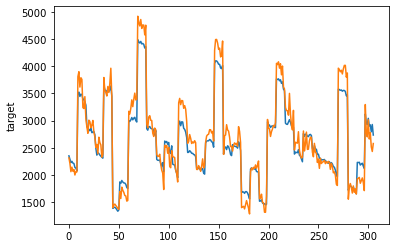

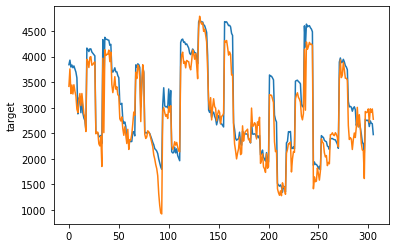

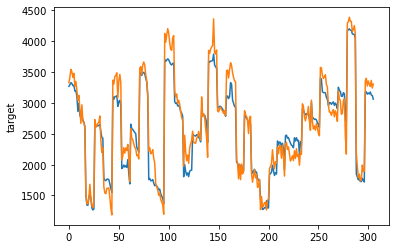

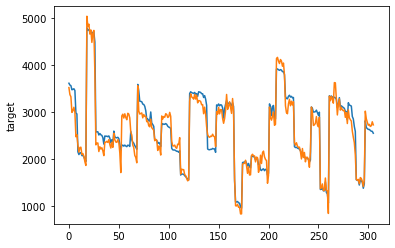

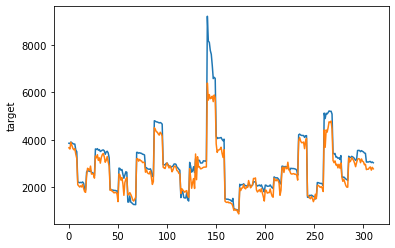

In [7]:
%matplotlib inline

fault_unique_patient_id = set([])
for i in range(5):
    a = pd.DataFrame({'pred': graph[i][-1]['pred'],'target': graph[i][-1]['target']})
    fig, ax = plt.subplots()
    sns.lineplot(x=[i for i in a.index], y=a['pred'], data=a)
    sns.lineplot(x=[i for i in a.index], y=a['target'], data=a)
    fault_unique_patient_id |= set(graph[i][-1]['fault_patient_id'])

print(fault_unique_patient_id)
train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
unique_train_data = train[train['Patient'].isin(list(fault_unique_patient_id))]
unique_train_data.to_csv('fault_patient.csv')# df = pd.DataFrame(s)
train[~train['Patient'].isin(list(fault_unique_patient_id))].to_csv('success_patient.csv')

# df[s.str.contains('og|at')] 
# new_data = data[data['a'].isin([1,2])]


# Predict Testdata

In [8]:
data = MedicalDataset(mode='test')
avg_preds = np.zeros((len(data), len(quantiles)))
print(data.FE)                     
print(data[0])
print(data.raw)
for model in models:
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=2)
    
    preds = []
    for batch in dataloader:
        inputs = batch['features'].float()
        with torch.no_grad():
            x = model(inputs)
            preds.append(x)
            
    preds = torch.cat(preds, dim=0).numpy()
    avg_preds += preds
    
avg_preds /= len(models)
df = pd.DataFrame(data = avg_preds, columns=list(quantiles))
print(df.head())
df['Patient_Week'] = data.raw['Patient_Week']
print(df.head())
df['FVC'] = df[quantiles[1]]
df['Confidence'] = df[quantiles[2]] - df[quantiles[0]]
df = df.drop(columns=list(quantiles))
df.to_csv('submission.csv', index=False)

['Male', 'Female', 'Ex-smoker', 'Never smoked', 'Currently smokes', 'Severe', 'Normal', 'Mild', 'Moderate', 'age', 'percent', 'week', 'BASE']
{'patient_id': 'ID00419637202311204720264', 'features': array([1.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.61538462,
       0.33242142, 0.06790123, 0.3723997 ]), 'target': 3020}
     index                    Patient  Weeks   FVC    Percent  Age   Sex  \
0     1540  ID00419637202311204720264    -12  3020  70.186855   73  Male   
1     1541  ID00419637202311204720264    -11  3020  70.186855   73  Male   
2     1542  ID00419637202311204720264    -10  3020  70.186855   73  Male   
3     1543  ID00419637202311204720264     -9  3020  70.186855   73  Male   
4     1544  ID00419637202311204720264     -8  3020  70.186855   73  Male   
..     ...                        ...    ...   ...        ...  ...   ...   
725   2265  ID00426637202313170790466    129  2925  71.824968   73  Male   

In [9]:
df.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2837.436230,344.616162
1,ID00419637202311204720264_-11,2835.448291,344.437402
2,ID00419637202311204720264_-10,2833.460400,344.259131
3,ID00419637202311204720264_-9,2831.471973,344.080127
4,ID00419637202311204720264_-8,2829.483984,343.902100
